**<h1> Disease Detection </h1>**

In this notebook, we will perform image classification to identify diseases in crops.

**<h2> Importing Libraries </h2>**

In [1]:
import sys
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import os
import h5py
import tensorflow as tf


**<h2> Mounting Drive and Setting Path</h2>**


In [2]:
#run this for flask-1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# run this for flask-2
train_path =r"/content/drive/My Drive/plant-diseases/train"
test_path = r"/content/drive/My Drive/plant-diseases/test"

**<h2> Getting Data and Preprocessing </h2>**

In [4]:
batch_size=32
img_height=299
img_width=299

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1750 files belonging to 7 classes.
Using 1400 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 17 files belonging to 5 classes.
Using 3 files for validation.


**<h3> Diseases Model will Detect </h3>**

In [7]:
class_names = train_ds.class_names
print(class_names)


['Bacterial leaf blight', 'Brown spot', 'Leaf smut', 'gray_leaf_spot', 'leaf_rust', 'northern_leaf_blight', 'stem_rust']


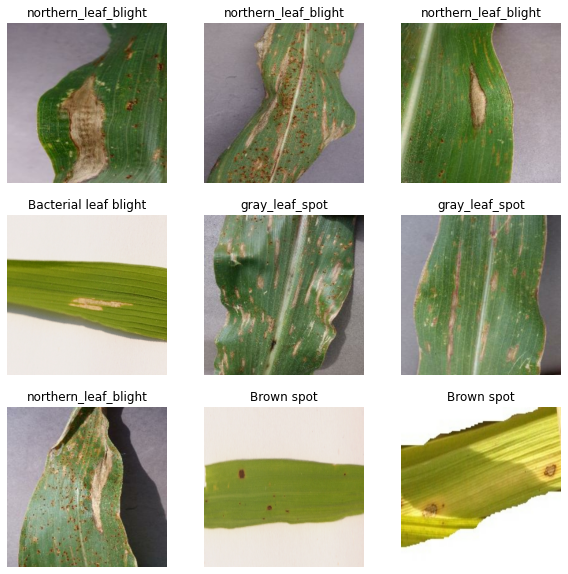

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**<h3> Normalizing Images </h3>**

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [10]:
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.06778124 0.8668799


**<h2> Convolutional Neural Network </h2>**

In [11]:
from tensorflow.keras.models import Sequential
num_classes = 7
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0

In [17]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
44/44 [==============================] - 1s 30ms/step - loss: 0.6024 - accuracy: 0.7371 - val_loss: 3.5009 - val_accuracy: 0.0000e+00
Epoch 2/10
44/44 [==============================] - 1s 30ms/step - loss: 0.5652 - accuracy: 0.7486 - val_loss: 2.0712 - val_accuracy: 0.3333
Epoch 3/10
44/44 [==============================] - 1s 30ms/step - loss: 0.5007 - accuracy: 0.7707 - val_loss: 5.8955 - val_accuracy: 0.3333
Epoch 4/10
44/44 [==============================] - 1s 30ms/step - loss: 0.4930 - accuracy: 0.7893 - val_loss: 6.9995 - val_accuracy: 0.0000e+00
Epoch 5/10
44/44 [==============================] - 1s 30ms/step - loss: 0.4618 - accuracy: 0.8000 - val_loss: 6.2776 - val_accuracy: 0.0000e+00
Epoch 6/10
44/44 [==============================] - 1s 30ms/step - loss: 0.4277 - accuracy: 0.8136 - val_loss: 9.1780 - val_accuracy: 0.0000e+00
Epoch 7/10
44/44 [==============================] - 1s 30ms/step - loss: 0.4143 - accuracy: 0.8193 - val_loss: 7.0628 - val_accuracy: 0.33

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

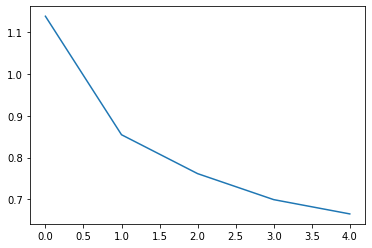

In [14]:
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])
#plt.legend(["loss","val_loss"])
plt.show()

**<h2>Testing Model </h2>**



In [15]:
#run this for flask-3
check="/content/drive/My Drive/plant-diseases/train/Brown spot/DSC_0100.jpg"
from tensorflow import keras
img = keras.preprocessing.image.load_img(
    check, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Brown spot with a 90.82 percent confidence.
